In [1]:
import os
from datetime import datetime, timedelta
import datetime as dt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Carga de datos positivos_covid

In [3]:
base_peru_url = 'https://raw.githubusercontent.com/JkaivaRevilla/Cluster-de-comportamiento/main/'
covidperu_cases_data_url = base_peru_url + 'positivoscovid_peru.csv'
covidperu = pd.read_csv(covidperu_cases_data_url)
covidperu.set_index('fecha_resultado', inplace=True)

In [4]:
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_cases_data_url = base_url + 'time_series_covid19_confirmed_global.csv'
raw_data_confirmed = pd.read_csv(confirmed_cases_data_url)

## tratamiento y estandarizacion de los datos

In [5]:
confirmed_country = raw_data_confirmed.groupby(['Country/Region']).sum().drop(['Lat', 'Long'], axis=1)
confirmed_country = confirmed_country.transpose()
confirmed_country.head(3)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


In [6]:
def convertir_fecha(fecha):
    partes = fecha.split('/')
    dia = partes[0]
    mes = partes[1]
    anio = partes[2]
    if int(anio) >= 20:
        anio = '20' + anio
    else:
        anio = '20' + anio
    return f'{dia}-{mes}-{anio}'

In [7]:
confirmed_country.reset_index(inplace=True)
confirmed_country.rename(columns={'index': 'fecha'}, inplace=True)
confirmed_country['fecha'] = confirmed_country['fecha'].apply(convertir_fecha)
confirmed_country.columns.name = None
confirmed_country['fecha'] = pd.to_datetime(confirmed_country['fecha'], format='%m-%d-%Y').dt.strftime('%m-%d-%Y')
confirmed_country['fecha'] = pd.to_datetime(confirmed_country['fecha'])
confirmed_country.set_index('fecha', inplace=True)
confirmed_country.index.name = None
datetime_index = pd.DatetimeIndex(confirmed_country.index)
confirmed_country.set_index(datetime_index, inplace=True)
confirmed_country = confirmed_country.loc[confirmed_country.index <= '2021-04-05']

In [8]:
confirmed_country.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,Australia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,2,0,0,0,0,0


### El siguiente trabajo es poder determinar que paises iniciaron mucho antes que Peru con un minimo de 2 contagios, este numero puede cambiar, pero nos daraun listado de paises en los cuales podremos tener mas informacion y evolucion de contagios

In [10]:
#Paises que hayan registrado contagios covid antes de 2020-03-01

data_diff = confirmed_country.diff(periods=1)
data_diff=data_diff.replace(np.nan,0)
#Lista de paises
paises=data_diff.columns.tolist()

zonas=[]
for pais in paises:
    x=data_diff[pais]
    #print(pais)
    x=x[x.index<='2020-03-01'].sum()
    if x >2:
        zonas.append(pais)  

In [11]:
#eliminacion de Zonas donde el contagio distorciona 
zonas.remove('Oman')
zonas.remove('US')
zonas.remove('Diamond Princess')
zonas.remove('United Arab Emirates')
zonas.remove('United Kingdom')
zonas.remove('China')

#### rellenar con valores de un dia anterior si es que esta vacio

In [12]:
data_pais=data_diff
for pais in paises:
    
    data_pais_up=data_pais[[pais]]
    data_pais_up['dia']=data_pais_up.shift(1)
    data_pais_up[[pais]] = np.where((data_pais_up[pais]<0),data_pais_up['dia'],data_pais_up[pais])
    del data_pais_up['dia']
    data_pais[pais]=data_pais_up[pais]

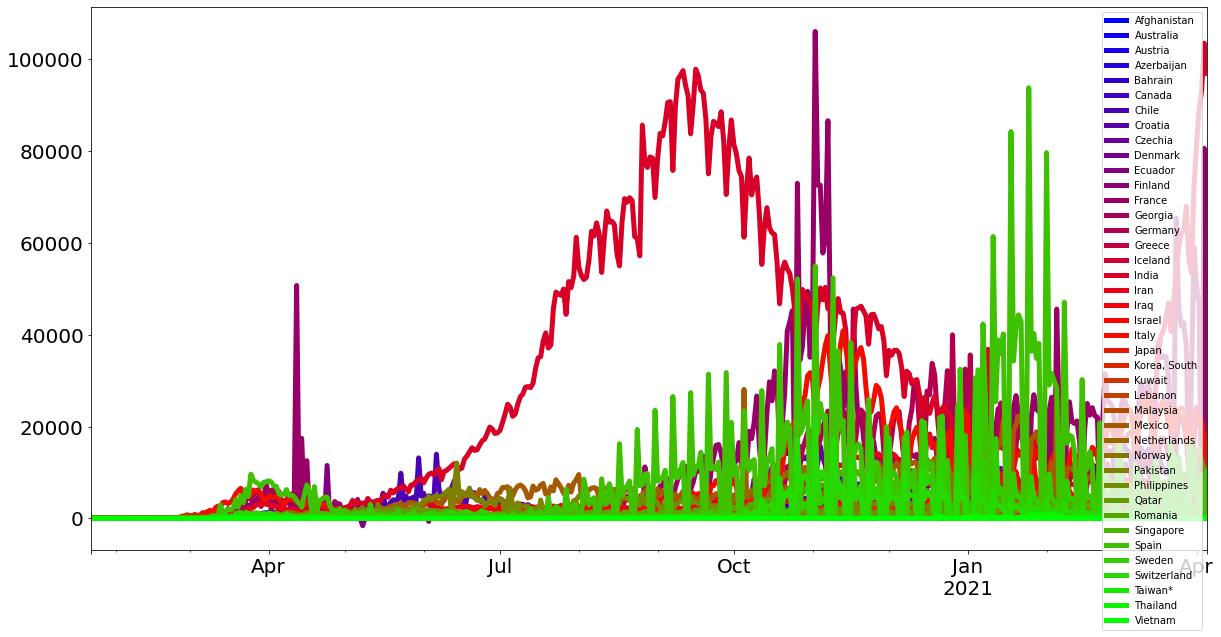

In [13]:
data_pais[zonas].plot(figsize=(20,10), linewidth=5, colormap='brg', fontsize=20);

### vamos a filtrar a todos los paises que iniciaron desde el 01 de febrero 2020. como antecedente se sabe que los contagios en Peru iniciaron el 07-03-2020

In [14]:
data_seleccionada=data_pais[zonas]
data_seleccionada=data_seleccionada.replace(np.nan,0)
data_seleccionada=data_seleccionada[data_seleccionada.index>='2020-02-01']

### Obtenemos la fecha de inicio de contagio en Peru(07-03-2020) y restaremos la fecha de contagio que tenemos(01-02-2020) con lo que obtendremos los dias de diferencias, estos dias seran restado a todas las fechas para poder estantadizar y tener a todos en un mismo inicio

In [16]:
d1=positivos_covidcantidad.index.min()
d2=data_seleccionada.index.min()
day=(d1-d2).days

In [17]:
positivos_covidcantidad.index= positivos_covidcantidad.index - timedelta(days=day)

### proceso de estandarizacion 

In [19]:
df_evaluacion=pd.merge(data_seleccionada,positivos_covidcantidad,left_index=True, right_index=True)
df_evaluacion.head(2)

,Afghanistan,Australia,Austria,Azerbaijan,Bahrain,Canada,Chile,Croatia,Czechia,Denmark,...,Qatar,Romania,Singapore,Spain,Sweden,Switzerland,Taiwan*,Thailand,Vietnam,Peru
2020-02-01,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,4.0,1
2020-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [21]:
col=df_evaluacion.columns

In [22]:
from sklearn.preprocessing import StandardScaler
se_2020=df_evaluacion.reset_index(drop=True)

sc=StandardScaler()
se_2020=sc.fit_transform(se_2020)
se_2020=pd.DataFrame(se_2020,
                    columns=col)
se_2020.head()

,Afghanistan,Australia,Austria,Azerbaijan,Bahrain,Canada,Chile,Croatia,Czechia,Denmark,...,Qatar,Romania,Singapore,Spain,Sweden,Switzerland,Taiwan*,Thailand,Vietnam,Peru
0,-0.683776,-0.528837,-0.758099,-0.616828,-1.378528,-1.011314,-1.187697,-0.632276,-0.770514,-0.722225,...,-0.9629,-0.907015,-0.596851,-0.629278,-0.465960,-0.540298,-0.591348,-0.448883,-0.182133,-1.494953
1,-0.683776,-0.553046,-0.758099,-0.616828,-1.378528,-1.011314,-1.187697,-0.632276,-0.770514,-0.722225,...,-0.9629,-0.907015,-0.601167,-0.629358,-0.466205,-0.540298,-0.591348,-0.448883,-0.524408,-1.493566
2,-0.683776,-0.553046,-0.758099,-0.616828,-1.378528,-1.011314,-1.187697,-0.632276,-0.770514,-0.722225,...,-0.9629,-0.907015,-0.609799,-0.629358,-0.466205,-0.540298,-0.591348,-0.448883,-0.353271,-1.494606
3,-0.683776,-0.544976,-0.758099,-0.616828,-1.378528,-1.010887,-1.187697,-0.632276,-0.770514,-0.722225,...,-0.9629,-0.907015,-0.583904,-0.629358,-0.466205,-0.540298,-0.347751,-0.409538,-0.524408,-1.494259
4,-0.683776,-0.553046,-0.758099,-0.616828,-1.378528,-1.010887,-1.187697,-0.632276,-0.770514,-0.722225,...,-0.9629,-0.907015,-0.592536,-0.629358,-0.466205,-0.540298,-0.591348,-0.448883,-0.524408,-1.494953


In [24]:
from trendypy.trendy import Trendy
from trendypy import utils
data_trendy=se_2020.replace(np.nan, 0.1)
data_trendy = data_trendy.apply(utils.scale_01)
trendy = Trendy(n_clusters=5) # 2

In [25]:
trendy.fit(data_trendy.T.values)#2.15

In [26]:
resultado_df=trendy.labels_
resultado_df =  pd.DataFrame(resultado_df,columns=['cluster'])

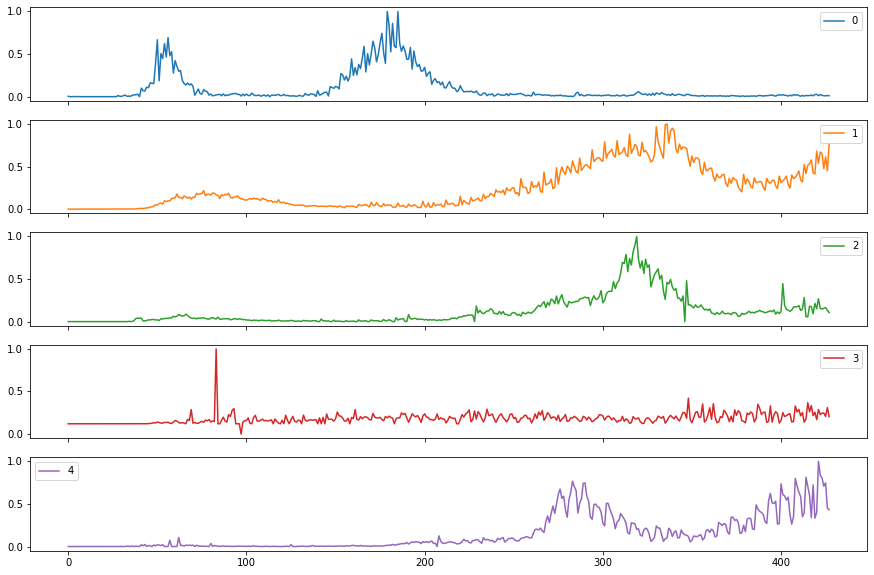

In [27]:
from matplotlib import pyplot as plt
#plt(trendy.cluster_centers_)
rr2=trendy.cluster_centers_

dfrr2 = pd.DataFrame(rr2).T
dfrr2.plot(subplots=True, figsize=(15, 10));

In [28]:
df_evaluacionf=df_evaluacion.reset_index(drop=True).T
df_evaluacionf=df_evaluacionf.rename_axis('pais').reset_index()
df_evaluacionf['cluster']=resultado_df

In [29]:
df_evaluacionf[df_evaluacionf['pais']=='Peru']

,pais,0,1,2,3,4,5,6,7,8,...,419,420,421,422,423,424,425,426,427,cluster
41,Peru,1.0,5.0,2.0,3.0,1.0,7.0,8.0,6.0,18.0,...,3776.0,2444.0,6210.0,6326.0,6735.0,6431.0,6426.0,4775.0,1584.0,4


In [30]:
import gc
gc.collect()

zonanew=df_evaluacionf[df_evaluacionf['cluster']==4]['pais'].tolist()

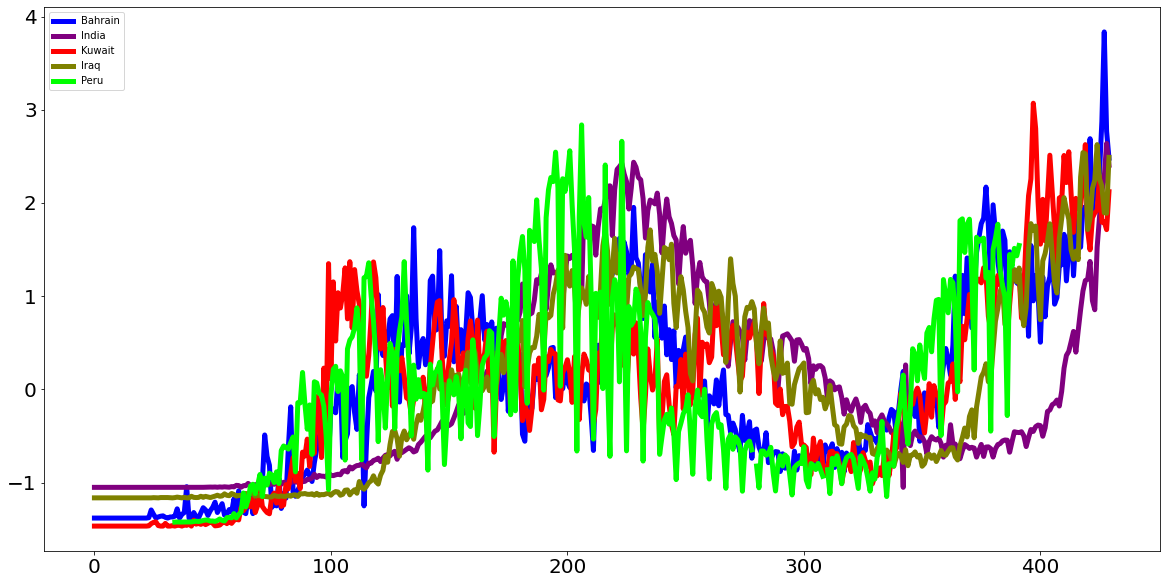

In [43]:
zonanew=['Bahrain','India','Kuwait','Iraq','Peru']
se_2020[zonanew].plot(figsize=(20,10), linewidth=5, colormap='brg', fontsize=20);